# Problem 1: K-means clustering and image compression (3pts)

### <div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2022 </div>

## Completed by:   
*   Artur Shevtsov
*   Maksym Leshchenko



### Description:
The aim of this assignment is to understand the K-means clustering algorithm and how it is used for image compression. You will implement the algorithm and then use it to assign the $m\times m$ blocks of the given image in $k$ clusters and then replace each block with the respective centroid. Visually, the quality of the image does not deteriorate much for moderate $m$ and large enough $k$, while its size drops down significantly as we only have to store the $k$ centroids and the cluster allocations of the blocks


### Links
For this task of your homework you can get **3 points** plus extra (see the last part).

To do some preliminary reading about K-Means algorithm, please check the following links:
*   https://scikit-learn.org/stable/modules/clustering.html
*   https://towardsdatascience.com/image-compression-using-k-means-clustering-aa0c91bb0eeb


### Initialization

In [1]:
from PIL import Image
import requests
from io import BytesIO

url = "https://images.unsplash.com/photo-1611915387288-fd8d2f5f928b?ixlib=rb-4.0.3&w=1080&fit=max&q=80&fm=jpg&crop=entropy&cs=tinysrgb"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [2]:
import numpy as np
import torch
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [3]:
def to_patches(img: torch.Tensor, psize) -> np.ndarray:
  return img.unfold(1, size=psize, step=psize).unfold(2,size=m, step=m).flatten(1,2).permute(1,0,2,3).numpy()

def visualize_patches(patches: np.ndarray, true_image_size=512, padding=0) -> Image:
  patch_tensor = torch.from_numpy(patches)
  return Image.fromarray(
      make_grid(patch_tensor, nrow=true_image_size // patches.shape[2], padding=padding
                ).permute(1,2,0).mul(255).to(torch.uint8).numpy())

## 1. K-Means Clustering from scratch (1 pt)

In this part, you will have to implement K-Means clustering algorithm for a dataset of points in $\mathbb{R}^n$. To this end, you are asked to implement the following methods:

*   random centroid initialization (choose random dataset points)
*   distance function
      *   Implement private methods with different distance metric (Euclidean, $\ell_1$, cosine, etc.)
*   allocation of points to clusters for given centroids
*   centroids update based on distance to all data points in respective clusters
*   and, finally, implement K-Means fitting loop, wich returns new fitted centroids





### Task 1: Complete the code below

In [4]:
import random
import numpy as np
from scipy.spatial.distance import cdist, cosine

class KMeans:

  def __init__(
      self,
      num_clusters=1,
      num_features=1,
      max_iter=1000,
      epsilon=1e-6,
      dist_metric="euclidean"
    ) -> None:
    self.K = num_clusters
    self.C = num_features
    self.I = max_iter
    self.E = epsilon
    self.metric = dist_metric

  def init_centroids(self, X: np.ndarray) -> np.ndarray:
    """
    Initialize centroids in random manner
    """
    assert (self.C) == X.shape[1]
    centroids = np.zeros((self.K, self.C))
    # ========= YOUR CODE STARTS HERE ========= #
    centroids = X[np.random.choice(X.shape[0], self.K)]
    # ========== YOUR CODE ENDS HERE ========== #
    return centroids

  def dist(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance from each point to each centroid,
    depending on a self.metric type
    """
    distances = np.zeros((X.shape[0], centroids.shape[0]))
    
    # ========= YOUR CODE STARTS HERE ========= #
    if self.metric == "euclidean":
      # Implementation of euclidean distance from scratch
      for i in range(X.shape[0]):
        for j in range(centroids.shape[0]):
          dist = np.sqrt(np.sum((X[i] - centroids[j])**2))
          distances[i][j] = dist
      
      # or use scipy.spatial.distance.cdist
      # distances = cdist(X, centroids, metric='euclidean')
          
    elif self.metric == "manhattan":
        for i in range(X.shape[0]):
          for j in range(centroids.shape[0]):
            dist = np.sum(np.abs(X[i] - centroids[j]))
            distances[i][j] = dist
            
    elif self.metric == "cosine":
      for i in range(X.shape[0]):
        for j in range(centroids.shape[0]):
          dist = 1 - np.dot(X[i], centroids[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(centroids[j]))
          distances[i][j] = dist
      
    else:
      raise NotImplementedError(f"Unknown metric {self.metric}")
    return distances
    # ========== YOUR CODE ENDS HERE ========== #


  def calc_mask(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance between data and centroids, pick closest centroid for each
    data point.
    """
    return self.dist(X, centroids).argmin(-1)

  def update_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute new centroids, by computing the mean of each centroid's cluster.

    Hint: Beware, with high value of K, some clusters centroid's can become
    redundant, and have no points belonging to them.
    """
    mask = self.calc_mask(X, centroids)
    new_centroids = np.zeros_like(centroids)
    # ========= YOUR CODE STARTS HERE ========= #
    new_centroids = np.array([np.mean(X[mask == i], axis=0) if X[mask == i].shape[0] > 0 else centroids[i] for i in range(self.K)])
    # ========== YOUR CODE ENDS HERE ========== #
    return new_centroids

  def predict(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    mask = self.calc_mask(X, centroids)
    return centroids[mask]

  def fit(self, X: np.ndarray) -> np.ndarray:
    """
    Implement training loop that looks like this:
    -- initialize new centroids
    -- for max_iter steps:
      -- update centroids
      -- compute delta between old and new centroids
      -- return centroids if delta < epsilon

    """
    
    centroids = self.init_centroids(X)
    for _ in range(self.I):
      # ========= YOUR CODE STARTS HERE ========= #
      new_centroids = self.update_clusters(X, centroids)
      delta = np.abs(new_centroids - centroids)
      if (delta < self.E).all():
        break
      
      centroids = new_centroids
      
      # ========== YOUR CODE ENDS HERE ========== #
        
    return centroids

## 2. Image compression using K-Means clustering (0.5 pt)

The dataset for clustering will be the $m\times m$ patches of the initial image. We split the image into patches with helper function **to_patches()**

In [5]:
m = 16 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

(1024, 3, 16, 16)

Let's see how our splitted image looks:
(You can change padding from 0 to another value, to see the grid)

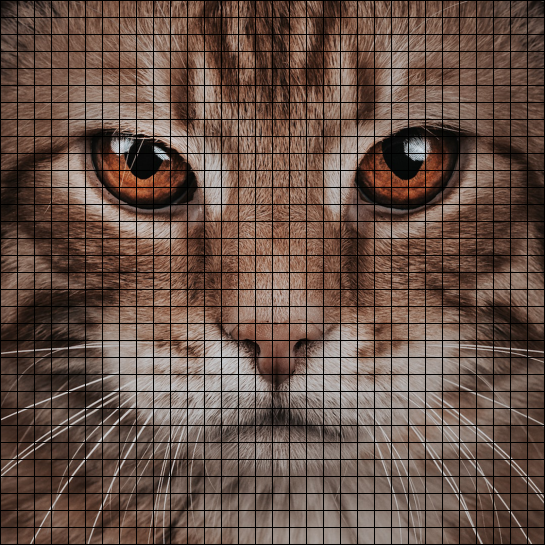

In [6]:
visualize_patches(patches, padding=1)

In [7]:
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(1024, 768)

### Try out your implementation!

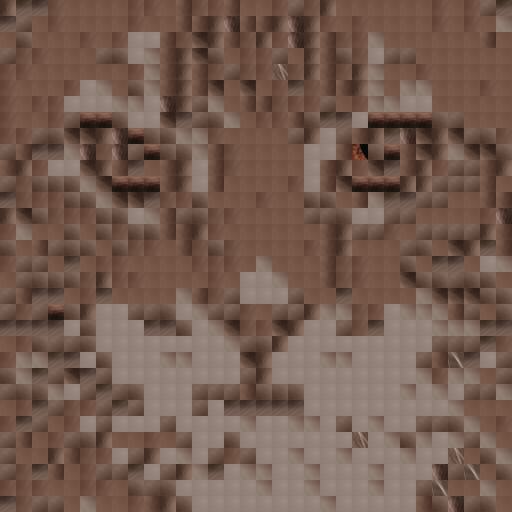

In [8]:
# initialize KMeans algo
kmeans = KMeans(15, data.shape[-1], max_iter=400, dist_metric="cosine")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m,m))

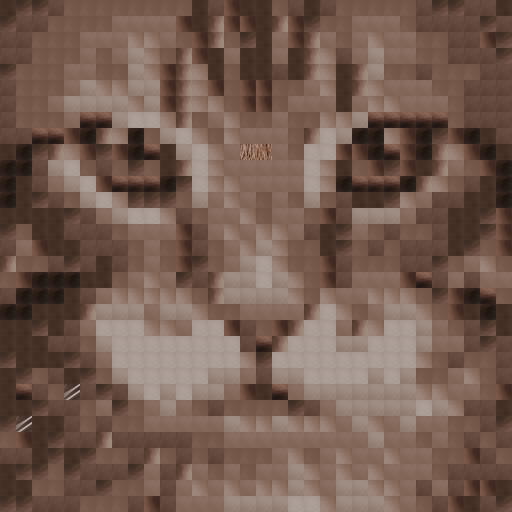

In [9]:
# initialize KMeans algo "cosine"
kmeans = KMeans(15, data.shape[-1], max_iter=400, dist_metric="euclidean")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)

visualize_patches(predicted.reshape(-1,3,m,m))

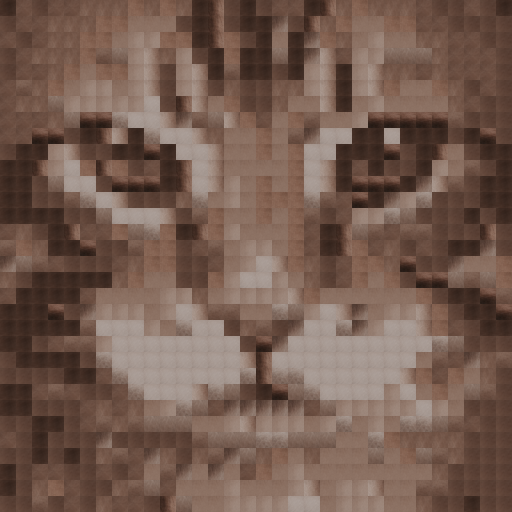

In [10]:
# initialize KMeans algo "cosine"
kmeans = KMeans(15, data.shape[-1], max_iter=400, dist_metric="manhattan")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m,m))

### Task 2: Discussion (0.5 pt)

 Using the implemented image compression algorithm, discuss the following topics:
1.  **Distance Metrics**: how do they influence of distance metrics on final result of fitting? (Provide visualizations and comments)
2.  **Compression rate**: what is the compression rate with different **k** (1,2,...,32) and **m**? What compression rate can we achieve without losing much quality?


---

1. Below you can find the results of compressing the image using different algorithms for computing the distances. As you can see, using the default values for the number of clusters, size of patch and number of iterations, we get pretty similar results from the `euclidean` and `manhattan` distances, and slightly worse from the `cosine`.
   
   The number of iterations strongly influences the result, and since in this algorithm we are using the random initialization of centroids, it has a major impact on the duration of the compressing by each algorithm. Even taking this fact into account, algorithms such as `euclidean` or `cosine` in average are much faster than `manhattan`. 
   
   The quality on the final picture mainly depends on the number of clusters. The more clusters we have, the better the quality of the final picture is. But the number of clusters is different for each distance algorithm. The `cosine similarity` gives the unidentifiable results up to 50 clusters, when the `euclidean` and `manhattan` distances give 
a picture with a familiar silhouette from 15 clusters.

---

2. Compression rate

### Results of the compression

#### Results of the compression using Euclidean distance
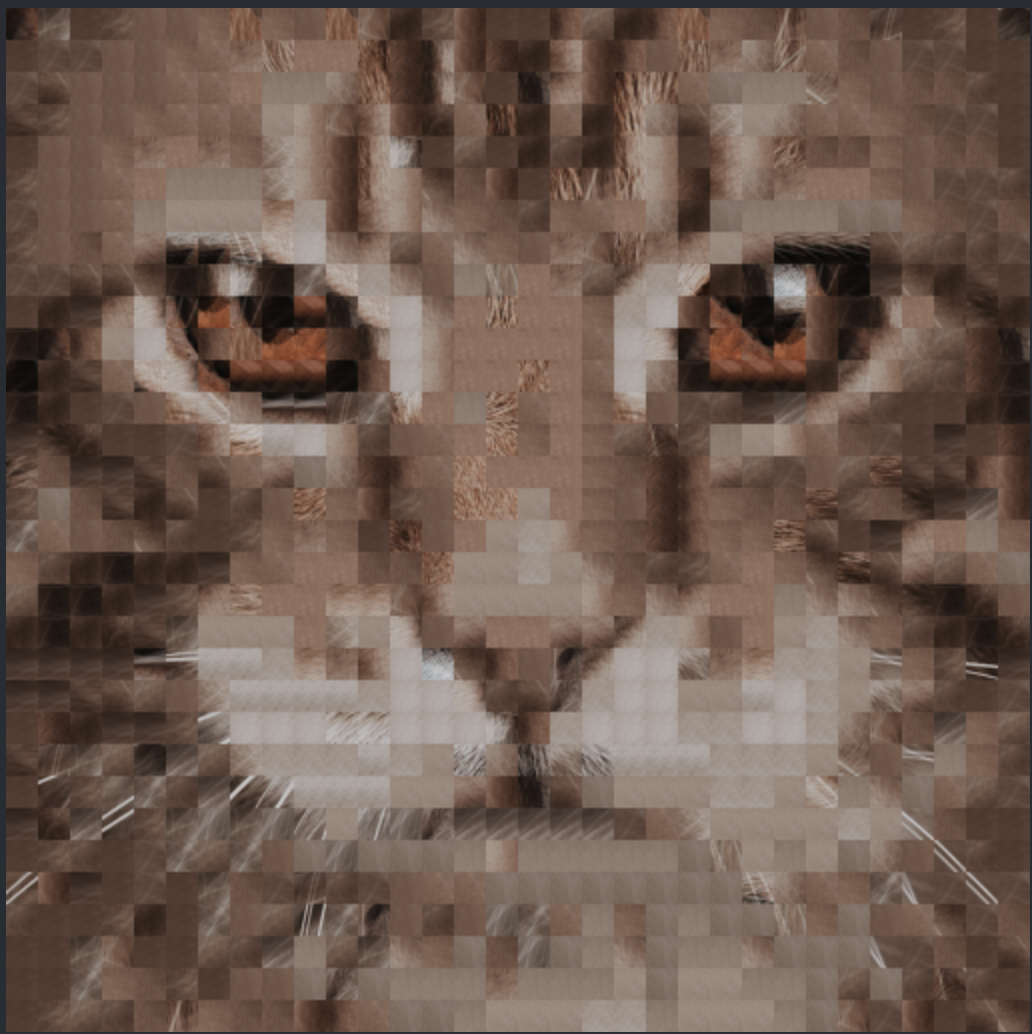

#### Results of the compression using Cosine distance
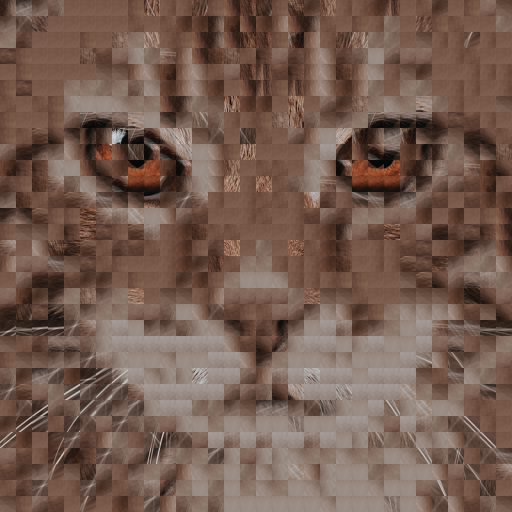

#### Results of the compression using Manhattan distance
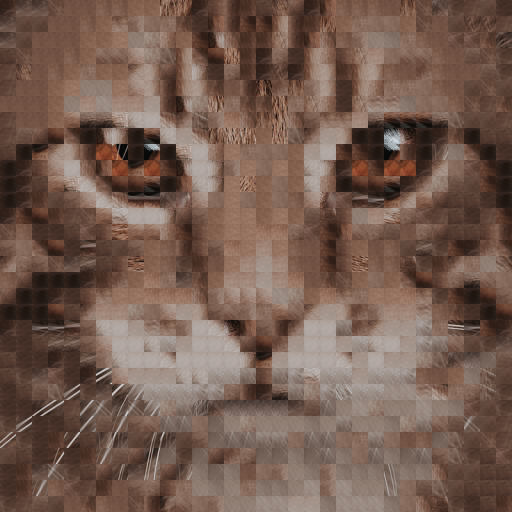
Number of clusters: 128


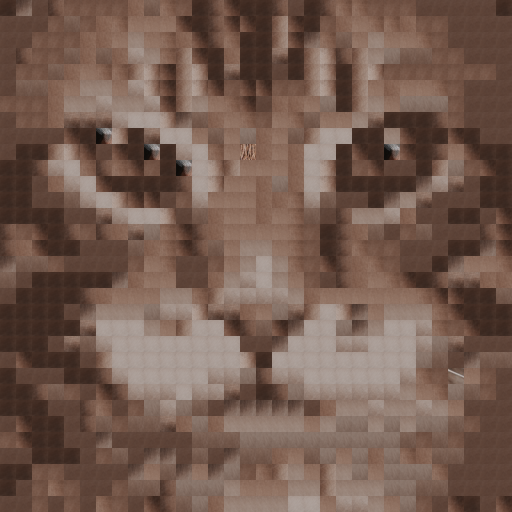
Number of clusters: 20

In [11]:
compression_rate = round((centroids.shape[0] * centroids.shape[1]) / (img_tensor.shape[0] * img_tensor.shape[1] * img_tensor.shape[2]) * 100, 2)
print(f"compression_rate in percentage: {compression_rate}%")

compression_rate in percentage: 1.46%


## 3. Elbow method (1 pt)

In this task, we will use the Elbow method to visualize the trade-off between quality and number of clusters **k** and try to select the best one!

##### To do some preliminary reading about Elbow Method, please, check the following link:
- https://stackabuse.com/k-means-clustering-with-the-elbow-method/

### Task 3: Implementation (0.3 pt)
Here we will implement the calculation of **Distortion** or **Inertia**, which are basically squared distances from each point to its assigned centroid.

In [12]:
## For each k run clustering algorithm and compute it's Distortion value
def calc_distoriton(data: np.ndarray, centroids:np.ndarray) -> float:
    distortion = 0
    # ========= YOUR CODE STARTS HERE ========= #
    mask = kmeans.calc_mask(data, centroids)
    for i in range(data.shape[0]):
      # distortion += np.sum((data[i][j] - centroids[i])**2)
      distortion += np.sum((data[i] - centroids[mask[i]])**2)
    distortion = round(distortion, 2)
    # ========== YOUR CODE ENDS HERE ========== #
    return distortion

### Task 4: Calculate & Visualize (0.4 pt)
Let's use above implemented function to calculate distortion for some **k** values and visualize our results

In [13]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

In [30]:
# You can choose your own values for the range
#(it may take some time to run the loop, so feel free to optimize your code ;=)
k_min = 2
k_max = 200
k_range = range(k_min, k_max, 2)

dfs_list = list()
dist_metric = "euclidean"
dist_algorithms = ["euclidean", "manhattan", "cosine"]

#calculate distortion values
for dist_algorithm in dist_algorithms:
  distortions = list()
  _temp_df = pd.DataFrame({'Clusters': k_range})
  _temp_df["distance_algorithm"] = dist_algorithm
  for k in k_range:

    # ========= YOUR CODE STARTS HERE ========= #
    kmeans = KMeans(k, data.shape[-1], max_iter=400, dist_metric=dist_algorithm)
    centroids = kmeans.fit(data)
    predicted = kmeans.predict(data, centroids)

    distortion = calc_distoriton(data, centroids)
    distortions.append(distortion)
  
  
  _temp_df.loc[_temp_df['distance_algorithm'] == dist_algorithm, 'Distortions'] = distortions
  dfs_list.append(_temp_df)
  
df = pd.concat(dfs_list)
  # ========== YOUR CODE ENDS HERE ========== #

# Plot your results
# ========= YOUR CODE STARTS HERE ========= #
fig = px.line(df, x='Clusters', y='Distortions', color="distance_algorithm").update_traces(mode='lines+markers')
fig.update_layout(title='Distortion vs. Number of Clusters', xaxis_title='Number of Clusters', yaxis_title='Distortion', legend_title_text="Distance Algorithm")
fig.show()
# ========== YOUR CODE ENDS HERE ========== #

### Task 5: Summarize (0.3 pt)

Discuss your results: what is the best trade-off between number of clusters and distortion?

What is the compression rate with this optimal value?

---

The best trade-off between number of clusters and distortion is different for every distance algorithm. For the `euclidean` and `manhattan` distances the best trade-off is 15 clusters, and for the `cosine` distance it is 50 clusters. The compression rate with this optimal value is 0.5 for the `euclidean` and `manhattan` distances, and 0.25 for the `cosine` distance.

---

## 4. Conclusions (0.5 pt)

---

### Task 6 (0.5 pt)
Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment

---

During this assignment we have learned how to use the K-means algorithm for image compression. We have implemented the algorithm from scratch and used it to assign the $m\times m$ blocks of the given image in $k$ clusters and then replace each block with the respective centroid. We have also implemented the Elbow method to visualize the trade-off between quality and number of clusters **k** and select the best one.

---

## 5. Bonus Problem (0.5 pt)
Besides compression, K-Means clustering can be used in more "creative" way -- using bigger patch sizes we can create cool "pop-art" mosaics :=)

*Hint*: you can replace fitted centroids with your own patches.

In [ ]:
m = 32 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

In [ ]:
# initialize KMeans algo "cosine"
kmeans = KMeans(3, data.shape[-1], max_iter=400, dist_metric="manhattan")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m,m))